<a href="https://colab.research.google.com/github/sheashea16/AlphaCapture/blob/main/pit_sight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pit Sight


*   A neural network designed to classify the number of stones in a singular pit.
*   Each pit (1-12), can have a minimum of zero (0) stones up to a maximum of twelve (12) stones.
*   A custom dataset that I created from images of my own board and labeling each pit was used.

In [1]:
# general imports
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

train_dir = "/content/drive/MyDrive/mancala_dataset/train"
val_dir   = "/content/drive/MyDrive/mancala_dataset/val"

Mounted at /content/drive


In [3]:
# define transforms
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ColorJitter(
        brightness=0.3,
        contrast=0.3,
        saturation=0.2
    ),
    transforms.ToTensor()
])

In [4]:
# create the dataset objects
train_ds = datasets.ImageFolder(train_dir, transform=transform)
val_ds   = datasets.ImageFolder(val_dir, transform=transform)

In [5]:
# CNN Model
import torch.nn as nn

class PitSight(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.classifier = nn.Linear(64, 13)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

In [6]:
# model architecture
model = PitSight()
print(model)

PitSight(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (classifier): Linear(in_features=64, out_features=13, bias=True)
)


In [7]:
# define loss function and optimizer
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [8]:
# select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [9]:
# create DataLoaders
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=16)

In [16]:
# training loop
num_epochs = 30

for epoch in range(num_epochs):
    # train
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    # validate
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = outputs.argmax(dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total if total > 0 else 0

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Acc: {val_acc:.2%}")


Epoch 1/30 | Train Loss: 0.9014 | Val Acc: 60.87%
Epoch 2/30 | Train Loss: 0.9312 | Val Acc: 60.87%
Epoch 3/30 | Train Loss: 0.8885 | Val Acc: 52.17%
Epoch 4/30 | Train Loss: 0.9132 | Val Acc: 56.52%
Epoch 5/30 | Train Loss: 0.9582 | Val Acc: 60.87%
Epoch 6/30 | Train Loss: 0.9028 | Val Acc: 60.87%
Epoch 7/30 | Train Loss: 0.9905 | Val Acc: 52.17%
Epoch 8/30 | Train Loss: 0.9155 | Val Acc: 60.87%
Epoch 9/30 | Train Loss: 0.8615 | Val Acc: 56.52%
Epoch 10/30 | Train Loss: 0.9010 | Val Acc: 56.52%
Epoch 11/30 | Train Loss: 0.9323 | Val Acc: 56.52%
Epoch 12/30 | Train Loss: 0.9039 | Val Acc: 56.52%
Epoch 13/30 | Train Loss: 0.8934 | Val Acc: 52.17%
Epoch 14/30 | Train Loss: 0.9097 | Val Acc: 47.83%
Epoch 15/30 | Train Loss: 0.9140 | Val Acc: 56.52%
Epoch 16/30 | Train Loss: 0.9375 | Val Acc: 56.52%
Epoch 17/30 | Train Loss: 0.9010 | Val Acc: 56.52%
Epoch 18/30 | Train Loss: 0.8692 | Val Acc: 47.83%
Epoch 19/30 | Train Loss: 0.9234 | Val Acc: 60.87%
Epoch 20/30 | Train Loss: 0.8735 | Val A

In [17]:
# save model
torch.save(model.state_dict(), "pitsight_3.pt")

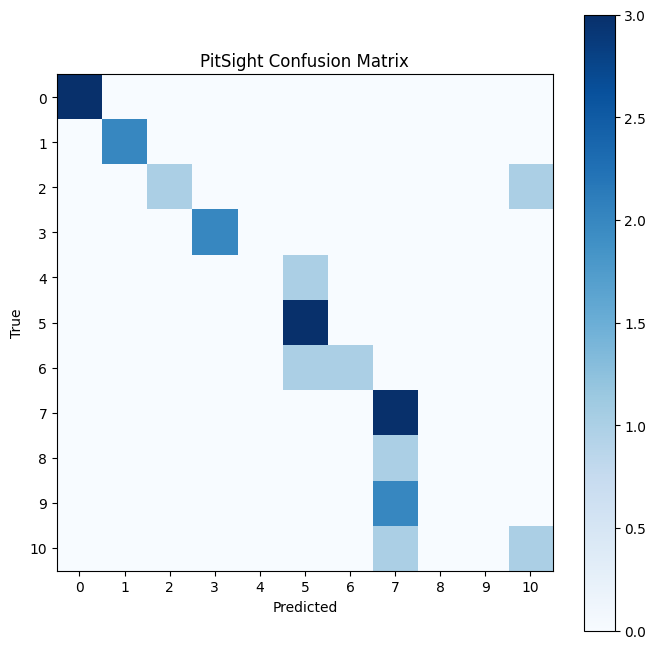

In [18]:
# visualize results
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 8))
plt.imshow(cm, cmap="Blues")
plt.colorbar()

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("PitSight Confusion Matrix")

plt.xticks(range(len(cm)))
plt.yticks(range(len(cm)))

plt.show()